In [17]:
import pandas as pd
import numpy as np


In [18]:
from tesi.database.di import get_session_maker
from tesi.zappai.di import (
    get_cds_api,
    get_climate_generative_model_repository,
    get_future_climate_data_repository,
    get_location_repository,
    get_past_climate_data_repository,
)
from tesi.zappai.repositories.dtos import ClimateDataDTO, FutureClimateDataDTO
from tesi.zappai.utils import common


session_maker = get_session_maker()
cds_api = get_cds_api()
location_repository = get_location_repository(session_maker=session_maker)
past_climate_data_repository = get_past_climate_data_repository(
    session_maker=session_maker,
    cds_api=cds_api,
    location_repository=location_repository,
)
future_climate_data_repository = get_future_climate_data_repository(
    session_maker=session_maker, cds_api=cds_api
)
climate_generative_model_repository = get_climate_generative_model_repository(
    session_maker=session_maker,
    location_repository=location_repository,
    past_climate_data_repository=past_climate_data_repository,
    future_climate_data_repository=future_climate_data_repository,
)

location = await location_repository.get_location_by_country_and_name(
    country=common.EXAMPLE_LOCATION_COUNTRY, name=common.EXAMPLE_LOCATION_NAME
)
if location is None:
    location = await location_repository.create_location(
        country=common.EXAMPLE_LOCATION_COUNTRY,
        name=common.EXAMPLE_LOCATION_NAME,
        longitude=common.EXAMPLE_LONGITUDE,
        latitude=common.EXAMPLE_LATITUDE,
    )
past_climate_data_df = ClimateDataDTO.from_list_to_dataframe(
    await past_climate_data_repository.get_past_climate_data(location.id)
)
future_climate_data_df = FutureClimateDataDTO.from_list_to_dataframe(
    await future_climate_data_repository.get_future_climate_data_for_nearest_coordinates(
        longitude=location.longitude,
        latitude=location.latitude,
        start_year=1970,
        start_month=1,
    )
)

await climate_generative_model_repository.delete_climate_generative_model(
    location_id=location.id
)
climate_generative_model, x_df_test, y_df_test = (
    await climate_generative_model_repository.create_model_for_location(
        location.id
    )
)
model = climate_generative_model.model
x_scaler = climate_generative_model.x_scaler
y_scaler = climate_generative_model.y_scaler


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4189 - root_mean_squared_error: 1.1910 - val_loss: 1.2901 - val_root_mean_squared_error: 1.1358
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2632 - root_mean_squared_error: 1.1238 - val_loss: 1.1099 - val_root_mean_squared_error: 1.0535
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0479 - root_mean_squared_error: 1.0234 - val_loss: 0.9565 - val_root_mean_squared_error: 0.9780
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8900 - root_mean_squared_error: 0.9432 - val_loss: 0.8175 - val_root_mean_squared_error: 0.9042
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7876 - root_mean_squared_error: 0.8872 - val_loss: 0.6931 - val_root_mean_squared_error: 0.8325
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6857 - root_mean_squared_error: 0.8279 - val_loss: 0.5760 - val_root_mean_squared_error: 0.7589
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.565

In [19]:
from typing import cast


x_test_scaled = cast(np.ndarray, x_scaler.transform(x_df_test))
y_test_scaled = cast(np.ndarray, y_scaler.transform(y_df_test))

In [20]:
SEQ_LENGTH = 12

In [21]:
generated_data = await climate_generative_model_repository.generate_climate_data_from_last_past_climate_data(
    location_id=location.id # type: ignore
)
generated_data

(55, 12)
(55, 10)


soil_temperature_level_3  volumetric_soil_water_layer_3  \
year month                                                            
2024 6                    293.890106                       0.194850   
     7                    292.896454                       0.180481   
     8                    292.896332                       0.180483   
     9                    292.810913                       0.189564   
     10                   292.826294                       0.194679   
     11                   294.251343                       0.184387   
     12                   297.060822                       0.174162   
2025 5                    298.276215                       0.173808   
     6                    292.815094                       0.190340   
     7                    292.897125                       0.180574   
     8                    292.811005                       0.189577   
     9                    293.889496                       0.194847   
     10                   294.063538                       0.181834   
     11                   297.261475                       0.175307   
     12                   297.060822                       0.174162   
2026 5                    297.361328                       0.206882   
     6                    291.364868                       0.207249   
     7                    291.350372                       0.207314   
     8                    291.616028                       0.189263   
     9                    292.853882                       0.185828   
     10                   292.198944                       0.192226   
     11                   294.862030                       0.189411   
     12                   295.863800                       0.177303   
2027 5                    297.043152                       0.207717   
     6                    290.961090                       0.217179   
     7                    291.169312                       0.195041   
     8                    291.434967                       0.176990   
     9                    292.816956                       0.185732   
     10                   291.764648                       0.184830   
     11                   296.201538                       0.165340   
     12                   296.000916                       0.164195   
2028 5                    297.180267                       0.194609   
     6                    291.189972                       0.194517   
     7                    291.175476                       0.194582   
     8                    292.427979                       0.191359   
     9                    292.816956                       0.185731   
     10                   291.764648                       0.184830   
     11                   296.064423                       0.178448   
     12                   296.543671                       0.213087   
2029 5                    297.043152                       0.207717   
     6                    290.785095                       0.225694   
     7                    290.946594                       0.217244   
     8                    291.297852                       0.190098   
     9                    292.853882                       0.185828   
     10                   292.198944                       0.192226   
     11                   296.064423                       0.178448   
     12                   296.813965                       0.201593   
2030 5                    299.012512                       0.182328   
     6                    292.293121                       0.192016   
     7                    291.334045                       0.204258   
     8                    291.343475                       0.189509   
     9                    292.686096                       0.198758   
     10                   292.117706                       0.197754   
     11                   296.064423                       0.178448   
     12                   295.872589

In [22]:
from tesi.zappai.repositories.climate_generative_model_repository import ClimateGenerativeModelRepository


# start generating from 1 year ago
seed_data = past_climate_data_df[(-12 - SEQ_LENGTH) : -12]
start_year, start_month = seed_data.index[-1]

filtered_future_climate_data_df = future_climate_data_df[
    ((future_climate_data_df.index.get_level_values("year") > start_year))
    | (
        (future_climate_data_df.index.get_level_values("year") == start_year)
        & (future_climate_data_df.index.get_level_values("month") > start_month)
    )
]

# this generated data start from one year ago
generated_data_df = climate_generative_model_repository.generate_data_from_seed(
    model=model,
    x_scaler=x_scaler,
    y_scaler=y_scaler,
    seed_data=seed_data,
    future_climate_data_df=filtered_future_climate_data_df,
)
true_data_df = past_climate_data_df[-12:]

In [23]:
from matplotlib import pyplot as plt

def plot_values(df: pd.DataFrame, values: list[str]):
    df_reset = df.reset_index()
    df_reset["YYYY-MM"] = (
        df_reset["year"].astype(str) + "-" + df_reset["month"].astype(str).str.zfill(2)
    )
    df_reset.plot(
        x="YYYY-MM",
        y=values,
        marker="o",
    )
    plt.xlabel("Month")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

/tmp/ipykernel_445726/4066554255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data_df["cmip5_2m_temperature"] = filtered_future_climate_data_df[:12]["2m_temperature"]


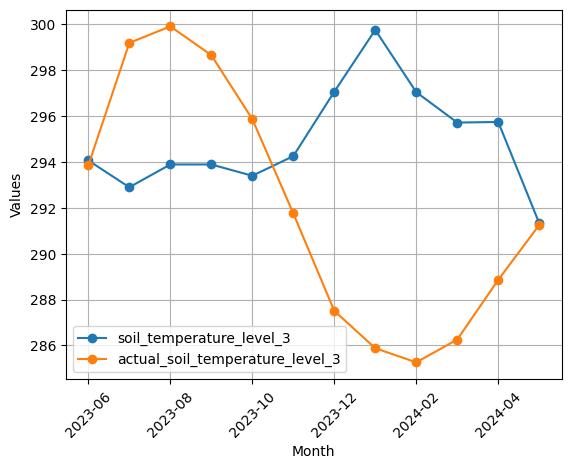

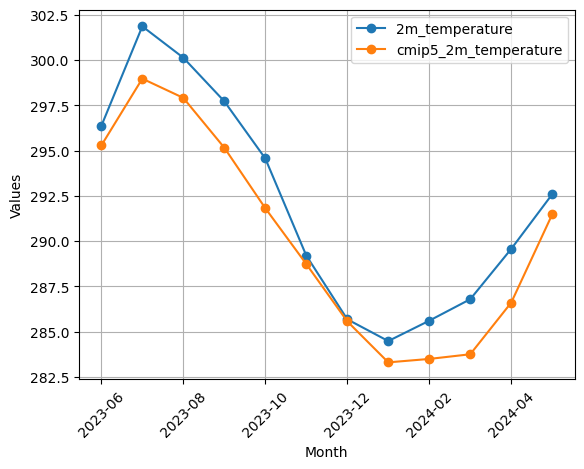

In [24]:
generated_data_df = generated_data_df[:12]
generated_data_df["actual_soil_temperature_level_3"] = true_data_df["soil_temperature_level_3"]
true_data_df["cmip5_2m_temperature"] = filtered_future_climate_data_df[:12]["2m_temperature"]
plot_values(df=generated_data_df, values=["soil_temperature_level_3", "actual_soil_temperature_level_3"])
plot_values(df=true_data_df, values=["2m_temperature", "cmip5_2m_temperature"])